In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/animals10/translate.py
/kaggle/input/animals10/raw-img/cavallo/OIP-mdvOxIWAyReAoEJcMk5z4wHaJ4.jpeg
/kaggle/input/animals10/raw-img/cavallo/OIP-TPYKs3XId_sMgp_6LLA6JgDMEy.jpeg
/kaggle/input/animals10/raw-img/cavallo/OIP-jlVRrokx7Vu1axi8OnTX2AHaE2.jpeg
/kaggle/input/animals10/raw-img/cavallo/OIP-F4QVZ71QagiynDMnFNxJUAHaEK.jpeg
/kaggle/input/animals10/raw-img/cavallo/OIP-UFtUZnXq0JHZo5R8UuF80wHaFj.jpeg
/kaggle/input/animals10/raw-img/cavallo/OIP-irWuWeIWd3Hm3BWGd0OEsQHaGO.jpeg
/kaggle/input/animals10/raw-img/cavallo/OIP-Y-hB14A3coI7TEgrEew0UAHaFj.jpeg
/kaggle/input/animals10/raw-img/cavallo/OIP-KqeKmYfnRwKd89nLg8_zRAHaHb.jpeg
/kaggle/input/animals10/raw-img/cavallo/OIP-s40xdXSQY099gt1hLGlzAwHaFP.jpeg
/kaggle/input/animals10/raw-img/cavallo/OIP-4k_sWoJ4_9-G1f0emDBVtwHaE6.jpeg
/kaggle/input/animals10/raw-img/cavallo/OIP-W-uUxHx-yovp1DQNtX1qdQHaFk.jpeg
/kaggle/input/animals10/raw-img/cavallo/OIP-Npxx8kemjjTljUyT9-BQgAHaFi.jpeg
/kaggle/input/animals10/raw-img/cavallo/OIP-jCu7nlv

In [2]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2

from tqdm import tqdm_notebook as tqdm
from sklearn.utils import class_weight, shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score
from keras.utils import to_categorical
from keras import applications, optimizers

from tensorflow.keras.models import Sequential, Model, load_model, clone_model
from tensorflow.keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.applications.resnet50 import ResNet50



2025-09-19 06:11:00.849146: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758262261.018587      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758262261.069516      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:

# extracting train data
foldernames = os.listdir("/kaggle/input/animals10/raw-img")
categories = []      # list of all categories of animals present
files = []           # list of all images from all categories

for k, folder in enumerate(foldernames):
    filenames = os.listdir(f"/kaggle/input/animals10/raw-img/{folder}")
    for file in filenames:
        files.append(f"/kaggle/input/animals10/raw-img/{folder}/{file}")
        categories.append(k)

# creating a dataframe of images and their respective categories        
df = pd.DataFrame({
    'filename': files,
    'category': categories
})

# collecting 500 samples from each of 10 categories
train_df = pd.concat(
    [df[df.category == i].iloc[:500, :] for i in range(10)],
    ignore_index=True
)

print(train_df.head())
print(train_df.shape)


                                            filename  category
0  /kaggle/input/animals10/raw-img/cavallo/OIP-md...         0
1  /kaggle/input/animals10/raw-img/cavallo/OIP-TP...         0
2  /kaggle/input/animals10/raw-img/cavallo/OIP-jl...         0
3  /kaggle/input/animals10/raw-img/cavallo/OIP-F4...         0
4  /kaggle/input/animals10/raw-img/cavallo/OIP-UF...         0
(5000, 2)


In [4]:
#shuffle
y = train_df['category']
x = train_df['filename']

x, y = shuffle(x, y, random_state=8)

In [5]:
#resizing and reshaping input image
def centering_image(img):
    size = [256,256]
    
#shape:(h×w×t)taking the first2 elements(h,w) and unpacking them appropriately 
    img_size = img.shape[:2]
    
    # extracting the excess space for centering.
    row = (size[1] - img_size[0]) // 2
    col = (size[0] - img_size[1]) // 2
    
#creating centered image by taking a 0-matrix and then re-assigning intensities
    resized = np.zeros(list(size) + [img.shape[2]], dtype=np.uint8)
    resized[row:(row + img.shape[0]), col:(col + img.shape[1])] = img 

    return resized

In [6]:
images = []

with tqdm(total=len(train_df)) as k:  
    for i, file_path in enumerate(train_df.filename.values):
        
        #color order is changed
        img = cv2.imread(file_path)
        #resnet docs
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

        #converting images to square
        if(img.shape[0] > img.shape[1]):
            tile_size = (int(img.shape[1]*256/img.shape[0]),256)
        else:
            tile_size = (256, int(img.shape[0]*256/img.shape[1]))

        #centering the images
        img = centering_image(cv2.resize(img, dsize=tile_size))

        #output 224*224px 
        img = img[16:240, 16:240]
        images.append(img)
        k.update(1)

images = np.array(images)

/tmp/ipykernel_36/452332963.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm(total=len(train_df)) as k:


  0%|          | 0/5000 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


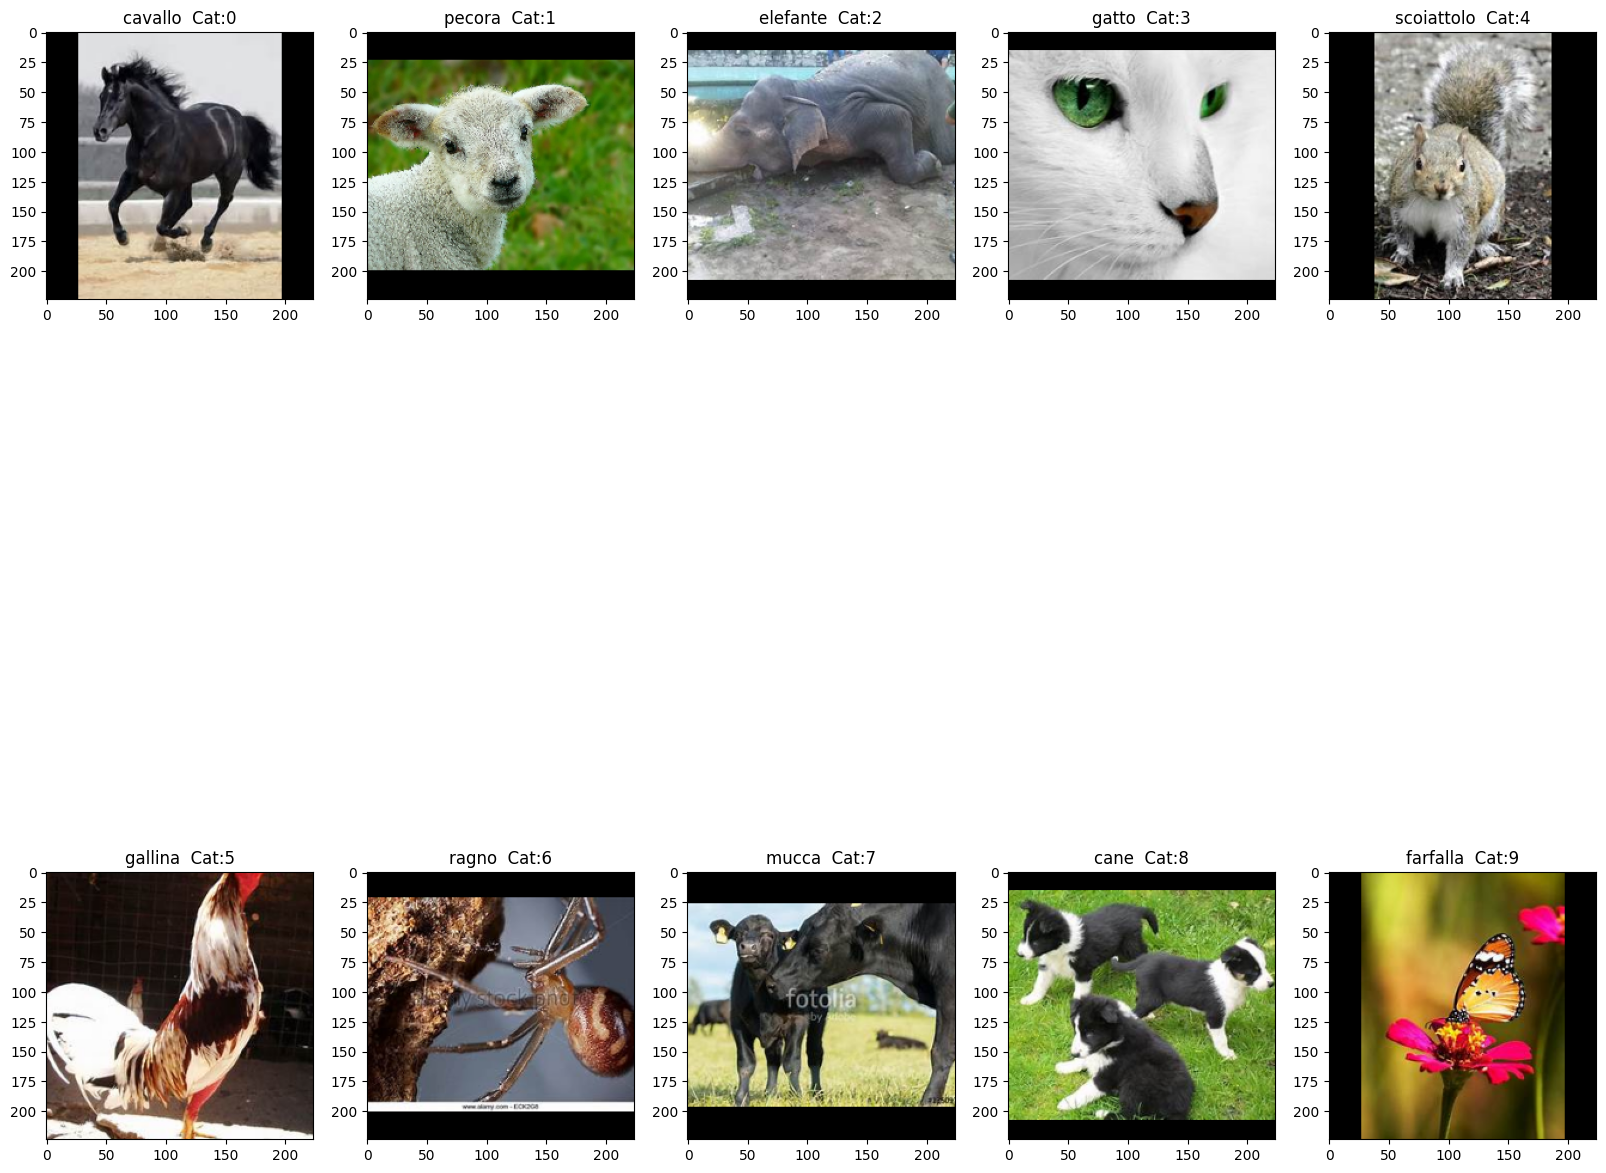

In [7]:
cols=5
fig, ax = plt.subplots(2,5, figsize=(20,20))
for i in range(10):
    path = train_df[train_df.category == i].values[1] #takes path in os of 1 value of figure of each category
#     print(path)
#     image = cv2.imread(path[0])  #     [i//cols, i%cols]
    ax[i//cols, i%cols].set_title(path[0].split('/')[-2] +' '+' Cat:'+ str(path[1])) # -2 is location of name of figure in path
    ax[i//cols, i%cols].imshow(images[train_df[train_df.filename == path[0]].index[0]])

In [8]:
data_num = len(y)
random_index = np.random.permutation(data_num)

x_shuffle = []
y_shuffle = []
for i in range(data_num):
    x_shuffle.append(images[random_index[i]])
    y_shuffle.append(y[random_index[i]])
    
x = np.array(x_shuffle) 
y = np.array(y_shuffle)

In [9]:
#train_test split
val_size = int(round(0.8*len(y)))
x_train = x[:val_size]
y_train = y[:val_size]
x_val = x[val_size:]
y_val = y[val_size:]

print('x_train Shape:', x_train.shape, '\t x_test Shape:',x_val.shape)
print('y_train Shape: ', y_train.shape, '\t y_test Shape:',y_val.shape)


y_train = to_categorical(y_train) 
y_val = to_categorical(y_val)

#dividing each intensity in array by 225 ( 225 is max intensity in RGB)
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_train /= 255 
x_val /= 255

print('x_train Shape:', x_train.shape, '\t x_test Shape:',x_val.shape)
print('y_train Shape: ', y_train.shape, '\t y_test Shape:',y_val.shape)
print('image Shape:', x_train[0].shape)

x_train Shape: (4000, 224, 224, 3) 	 x_test Shape: (1000, 224, 224, 3)
y_train Shape:  (4000,) 	 y_test Shape: (1000,)
x_train Shape: (4000, 224, 224, 3) 	 x_test Shape: (1000, 224, 224, 3)
y_train Shape:  (4000, 10) 	 y_test Shape: (1000, 10)
image Shape: (224, 224, 3)


In [10]:
animal_names = [] 
for i in range(10):
    path = train_df[train_df.category == i].values[1]
    if path[0].split('/')[-2] == 'scoiattolo':
        animal_names.append('squirrel')
    elif path[0].split('/')[-2] == 'cavallo':
        animal_names.append('horse')
    elif path[0].split('/')[-2] == 'farfalla':
        animal_names.append('butterfly')
    elif path[0].split('/')[-2] == 'mucca':
        animal_names.append('cow')
    elif path[0].split('/')[-2] == 'gatto':
        animal_names.append('cat')
    elif path[0].split('/')[-2] == 'pecora':
        animal_names.append('sheep')
    elif path[0].split('/')[-2] == 'gallina':
        animal_names.append('chicken')
    elif path[0].split('/')[-2] == 'elefante':
        animal_names.append('elephant')
    elif path[0].split('/')[-2] == 'ragno':
        animal_names.append('spider')
    elif path[0].split('/')[-2] == 'cane':
        animal_names.append('dog')

In [11]:
# ImageDataGenerator for data augmentation 

train_data_gen = ImageDataGenerator(rotation_range=45, 
                                    width_shift_range=0.1,
                                    height_shift_range=0.1, 
                                    horizontal_flip=True)
train_data_gen.fit(x_train) 

In [12]:
test_images = []

# collect test filepaths and labels
test_df = pd.concat(
    [df[df.category == i].iloc[500:502, :1] for i in range(10)],
    ignore_index=True
)

actual_pred = pd.concat(
    [df[df.category == i].iloc[500:502, 1:] for i in range(10)],
    ignore_index=True
)

# load and preprocess test images
with tqdm(total=len(test_df)) as k:  
    for i, file_path in enumerate(test_df.filename.values):
        
        # read image
        img = cv2.imread(file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

        # resize proportionally
        if img.shape[0] > img.shape[1]:
            tile_size = (int(img.shape[1] * 256 / img.shape[0]), 256)
        else:
            tile_size = (256, int(img.shape[0] * 256 / img.shape[1]))

        # center the image (make sure centering_image is defined elsewhere)
        img = centering_image(cv2.resize(img, dsize=tile_size))

        # crop to 224x224
        img = img[16:240, 16:240]

        test_images.append(img)
        k.update(1)

# final array
test_images = np.array(test_images).reshape(-1, 224, 224, 3)


/tmp/ipykernel_36/807329032.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm(total=len(test_df)) as k:


  0%|          | 0/20 [00:00<?, ?it/s]

In [13]:
from tensorflow.keras import optimizers

# hyperparameters
epochs = 25
learning_rate = 0.001
momentum = 0.9

# define optimizer
sgd = optimizers.SGD(learning_rate=learning_rate, momentum=momentum, nesterov=False)

# base model
base_model1 = applications.VGG16(weights='imagenet', include_top=False,
                                 input_shape=(224,224,3))

# custom top layers
model1 = Sequential()
model1.add(Flatten(input_shape= base_model1.output_shape[1:]))
model1.add(Dense(256, activation='relu'))
model1.add(Dense(10, activation='softmax'))

# full model
vgg16_model = Model(inputs=base_model1.input,
                    outputs=model1(base_model1.output))

# compile
vgg16_model.compile(loss='categorical_crossentropy',   # better for multi-class
                    optimizer=sgd,
                    metrics=['accuracy'])

vgg16_model.summary()


I0000 00:00:1758262316.911138      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758262316.911804      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 10)             │     6,425,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,140,042 (80.64 MB)

 Trainable params: 21,140,042 (80.64 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
from tensorflow.keras import optimizers

epochs = 25
learning_rate = 0.001
momentum = 0.8

# Correct: use learning_rate instead of lr, remove decay
sgd = optimizers.SGD(learning_rate=learning_rate, momentum=momentum, nesterov=False)

base_model2 = ResNet50(weights=None, include_top=False, input_shape=(224,224,3))
model2 = Sequential()
model2.add(Flatten(input_shape= base_model2.output_shape[1:]))
model2.add(Dense(256, activation='relu'))
model2.add(Dense(10, activation='softmax'))

ResNet50_model = Model(inputs=base_model2.input,
                       outputs=model2(base_model2.output))

# Use categorical_crossentropy for 10-class classification
ResNet50_model.compile(loss='categorical_crossentropy',
                       optimizer=sgd,
                       metrics=['accuracy'])

ResNet50_model.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 49,280,650 (187.99 MB)

 Trainable params: 49,227,530 (187.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [15]:
batch_size = 32  # hyperparameters
epochs = 30  

neural_ntwk2 = ResNet50_model.fit(
    train_data_gen.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=x_train.shape[0] // batch_size,
    validation_data=(x_val, y_val),
    epochs=epochs,
    callbacks=[
        ModelCheckpoint(
            'ResNet50transferlearning.keras',
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        )

    ]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1758262350.323420     104 service.cc:148] XLA service 0x7b4150002a80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758262350.324151     104 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758262350.324174     104 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758262352.540836     104 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1758262370.217119     104 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.0891 - loss: 5.2869
Epoch 1: val_accuracy improved from -inf to 0.09600, saving model to ResNet50transferlearning.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 102s 437ms/step - accuracy: 0.0891 - loss: 5.2705 - val_accuracy: 0.0960 - val_loss: 2.3025
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.0964 - loss: 2.3026
Epoch 2: val_accuracy did not improve from 0.09600
125/125 ━━━━━━━━━━━━━━━━━━━━ 44s 349ms/step - accuracy: 0.0964 - loss: 2.3026 - val_accuracy: 0.0920 - val_loss: 2.3028
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.0947 - loss: 2.3025
Epoch 3: val_accuracy improved from 0.09600 to 0.09900, saving model to ResNet50transferlearning.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 46s 363ms/step - accuracy: 0.0948 - loss: 2.3025 - val_accuracy: 0.0990 - val_loss: 2.3034
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.1015 - loss: 2.3033
Epoch 4: val_accuracy did not improve from 0

In [16]:
batch_size = 32 
epochs = 25  

neural_ntwk1 = vgg16_model.fit(
    train_data_gen.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=x_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[
        ModelCheckpoint(
            'VGG16-transferlearning.keras',   # must end in .keras or .h5
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        )
    ]
)


Epoch 1/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.3197 - loss: 1.9213
Epoch 1: val_accuracy improved from -inf to 0.77200, saving model to VGG16-transferlearning.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 123s 670ms/step - accuracy: 0.3212 - loss: 1.9174 - val_accuracy: 0.7720 - val_loss: 0.6552
Epoch 2/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.7779 - loss: 0.6469
Epoch 2: val_accuracy improved from 0.77200 to 0.85200, saving model to VGG16-transferlearning.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 66s 528ms/step - accuracy: 0.7779 - loss: 0.6467 - val_accuracy: 0.8520 - val_loss: 0.4334
Epoch 3/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.8391 - loss: 0.4776
Epoch 3: val_accuracy improved from 0.85200 to 0.88400, saving model to VGG16-transferlearning.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 66s 528ms/step - accuracy: 0.8391 - loss: 0.4775 - val_accuracy: 0.8840 - val_loss: 0.3497
Epoch 4/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.8689 - 

In [20]:
def show_plots(neural_ntwk):
    loss_vals = neural_ntwk['loss']
    val_loss_vals = neural_ntwk['val_loss']
    epochs = range(1, len(neural_ntwk['accuracy'])+1)
    
    f, ax = plt.subplots(nrows=1,ncols=2,figsize=(16,4))
    
    ax[0].plot(epochs, loss_vals, color='red', marker='o',
               linestyle='-', label='Train Loss')
    ax[0].plot(epochs, val_loss_vals, color='blue',
               marker='*', label='Val Loss')
    ax[0].set(title='Train & Val Loss', xlabel='Epochs',ylabel='Loss')
    ax[0].legend(loc='best')
    ax[0].grid(True)
    
    # plot accuracies
    acc_vals = neural_ntwk['accuracy']
    val_acc_vals = neural_ntwk['val_accuracy']

    ax[1].plot(epochs, acc_vals, color='navy', marker='o',
               ls='-', label='Train Accuracy')
    ax[1].plot(epochs, val_acc_vals, color='firebrick',
               marker='*', label='Val Accuracy')
    ax[1].set(title='Train & Val Accuracy',xlabel='Epochs',ylabel='Accuracy')
    ax[1].legend(loc='best')
    ax[1].grid(True)
    
    plt.show()
    plt.close()
    
    # cleanup
    del loss_vals, val_loss_vals, epochs, acc_vals, val_acc_vals


ResNet50: Epochs=30, Train accuracy=0.15850, Val accuracy=0.14100
VGG16: Epochs=25, Train accuracy=0.98725, Val accuracy=0.93300


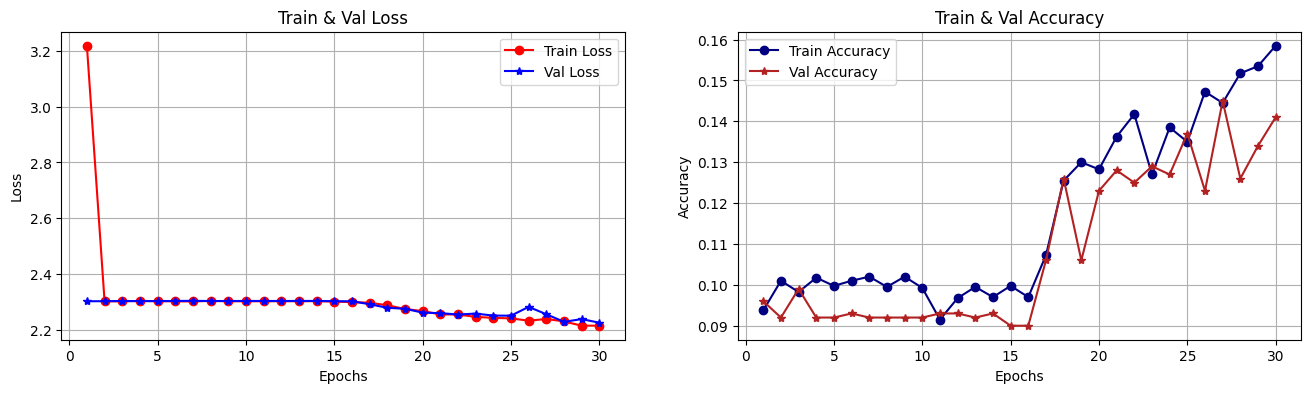

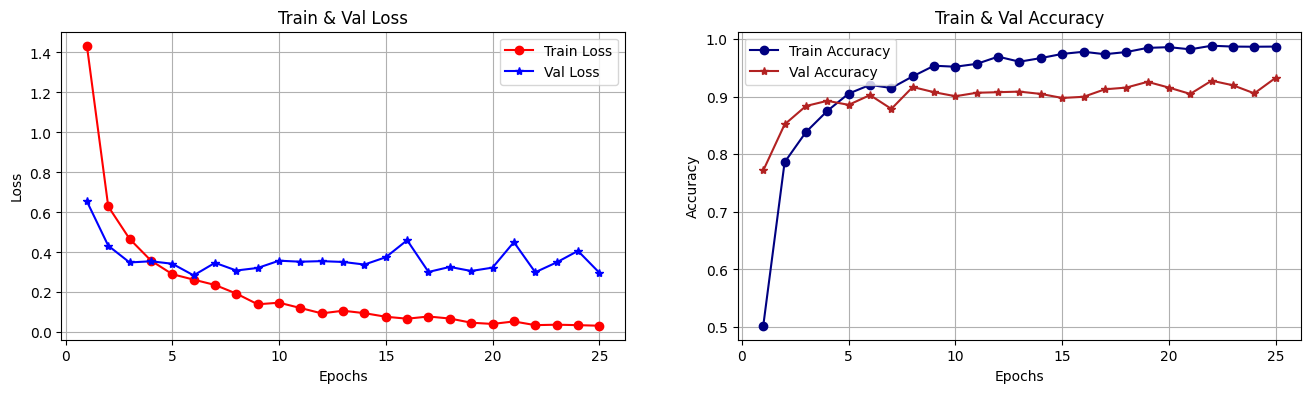

In [21]:
epochs_resnet = len(neural_ntwk2.history['accuracy'])
epochs_vgg = len(neural_ntwk1.history['accuracy'])

print("ResNet50: Epochs={0:d}, Train accuracy={1:.5f}, Val accuracy={2:.5f}"
      .format(epochs_resnet,
              neural_ntwk2.history['accuracy'][epochs_resnet-1],
              neural_ntwk2.history['val_accuracy'][epochs_resnet-1]))

print("VGG16: Epochs={0:d}, Train accuracy={1:.5f}, Val accuracy={2:.5f}"
      .format(epochs_vgg,
              neural_ntwk1.history['accuracy'][epochs_vgg-1],
              neural_ntwk1.history['val_accuracy'][epochs_vgg-1]))

show_plots(neural_ntwk2.history)
show_plots(neural_ntwk1.history)


In [22]:
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess

test_images_vgg = vgg16_preprocess(test_images.copy())
test_images_resnet = resnet_preprocess(test_images.copy())


test_prediction1 = vgg16_model.predict(test_images)
test_prediction2 = ResNet50_model.predict(test_images)

pred_classes1 = np.argmax(test_prediction1, axis=1)
pred_classes2 = np.argmax(test_prediction2, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


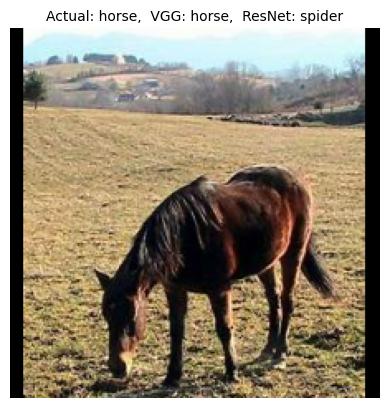

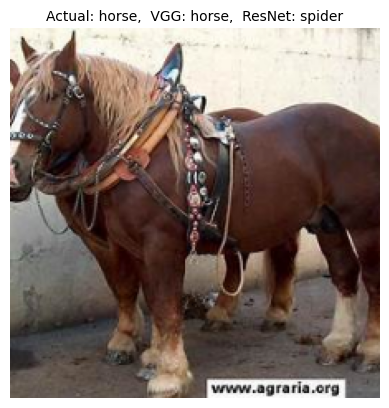

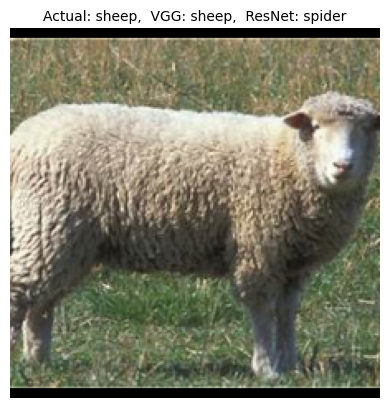

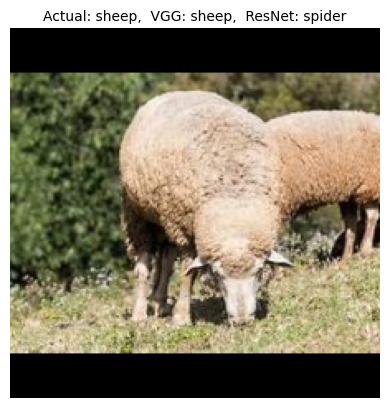

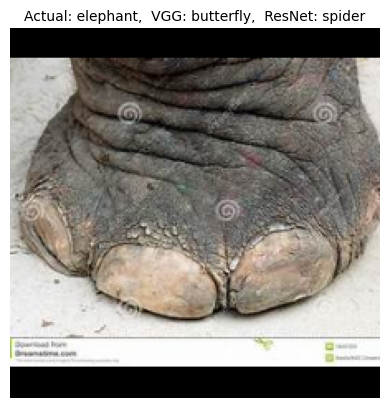

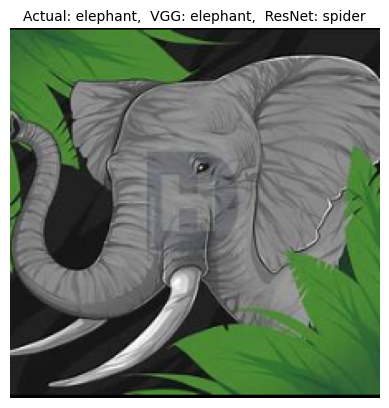

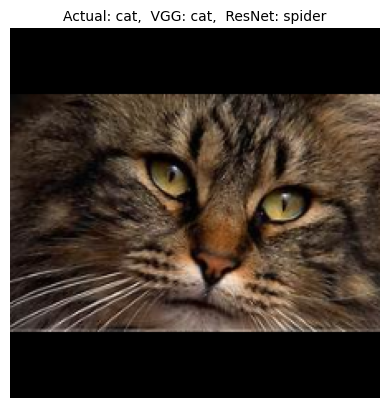

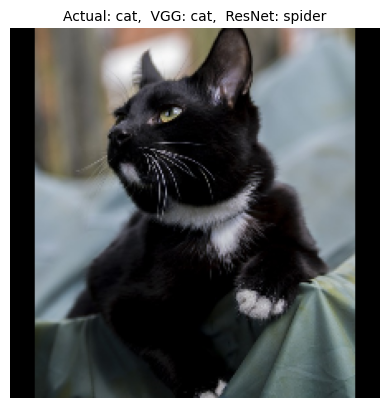

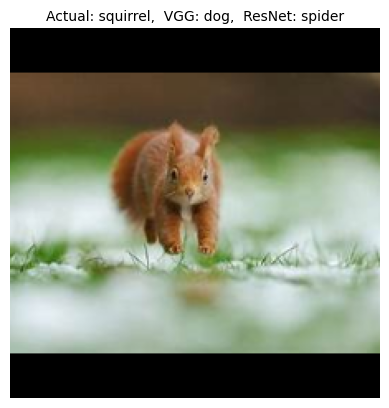

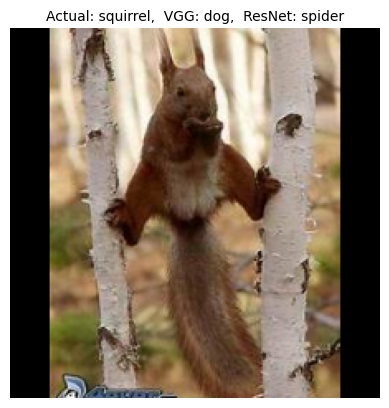

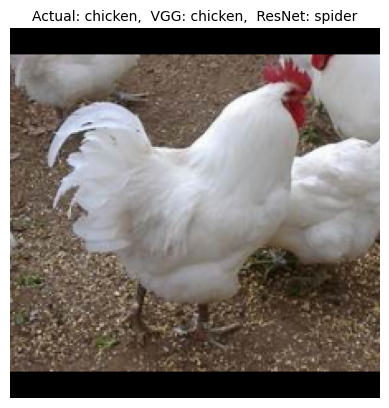

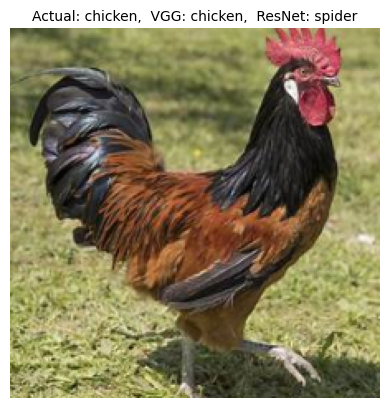

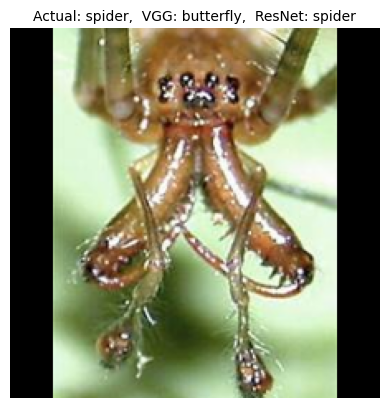

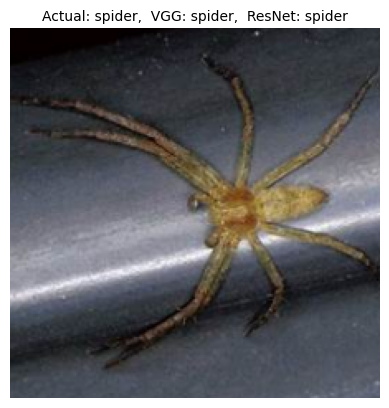

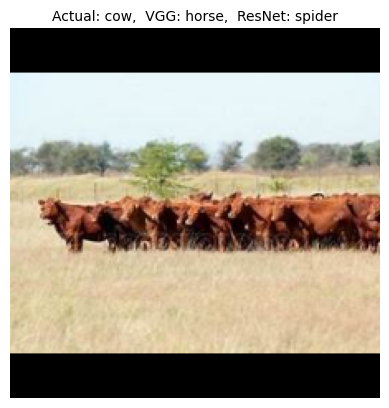

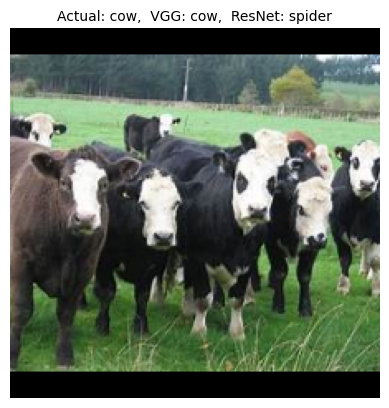

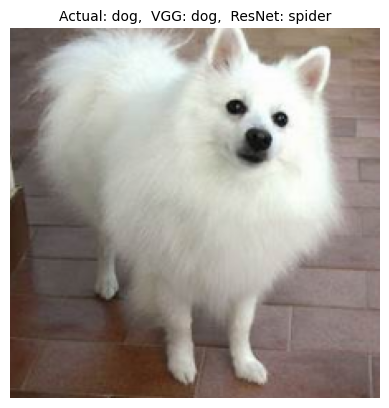

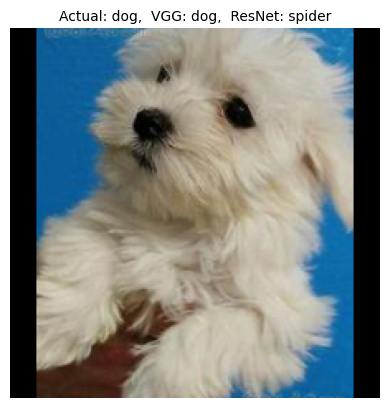

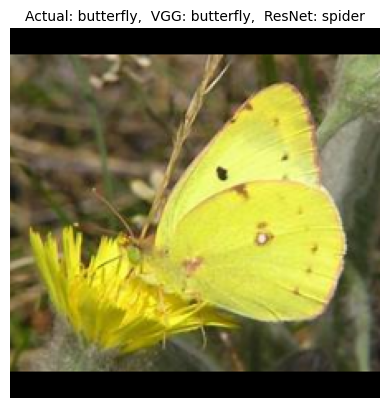

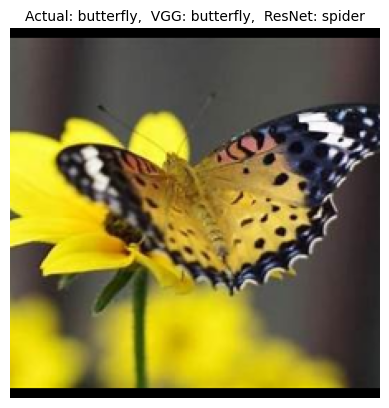

In [23]:
for i in range(20):
    predict1 = test_prediction1[i].argmax()
    predict2 = test_prediction2[i].argmax()
    actual = actual_pred['category'][i]

    plt.imshow(test_images[i])
    plt.title("Actual: {0},  VGG: {1},  ResNet: {2}".format(
        animal_names[actual],
        animal_names[predict1],
        animal_names[predict2]),
        fontsize=10
    )
    plt.axis('off')
    plt.show()
